# Task 2: Comprehensive Exploratory Data Analysis

**Objective**: Analyze patterns, trajectories, and relationships in Ethiopia's financial inclusion data.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import numpy as np
import importlib

# Add src to path
sys.path.append(os.path.abspath(os.path.join('../src')))

# Auto-reload modules
%load_ext autoreload
%autoreload 2

import data_loader
importlib.reload(data_loader)
from data_loader import load_data
from analyze_data import analyze_access_slowdown, analyze_gender_gap

sns.set_theme(style="whitegrid")
df = load_data(data_path=r"../data/raw/ethiopia_fi_unified_data.xlsx")
print(f"Data loaded: {len(df)} records")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading data from ../data/raw/ethiopia_fi_unified_data.xlsx...
Loaded 43 records from Excel.
Enriching with 3 new records...
Data loaded: 46 records


c:\Users\Jose\Desktop\KAIM8\WEEK10\codes\ethiopia-fi-forecast\src\data_loader.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_unified = pd.concat([df, df_enrich], ignore_index=True)
c:\Users\Jose\Desktop\KAIM8\WEEK10\codes\ethiopia-fi-forecast\src\data_loader.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_unified = pd.concat([df, df_enrich], ignore_index=True)
c:\Users\Jose\Desktop\KAIM8\WEEK10\codes\ethiopia-fi-forecast\src\data_loader.py:86: UserWarning: Could not infer format

## 1. Dataset Overview
**Temporal Coverage**: Which years have data?

Data Coverage Shape: (19, 6)
data_year       2014.0  2017.0  2021.0  2023.0  2024.0  2025.0
indicator_code                                                
ACC_4G_COV         NaN     NaN     NaN     1.0     NaN     1.0
ACC_FAYDA          NaN     NaN     NaN     NaN     1.0     2.0
ACC_MM_ACCOUNT     NaN     NaN     1.0     NaN     1.0     NaN
ACC_MOBILE_PEN     NaN     NaN     NaN     NaN     NaN     1.0
ACC_OWNERSHIP      1.0     1.0     3.0     NaN     1.0     NaN


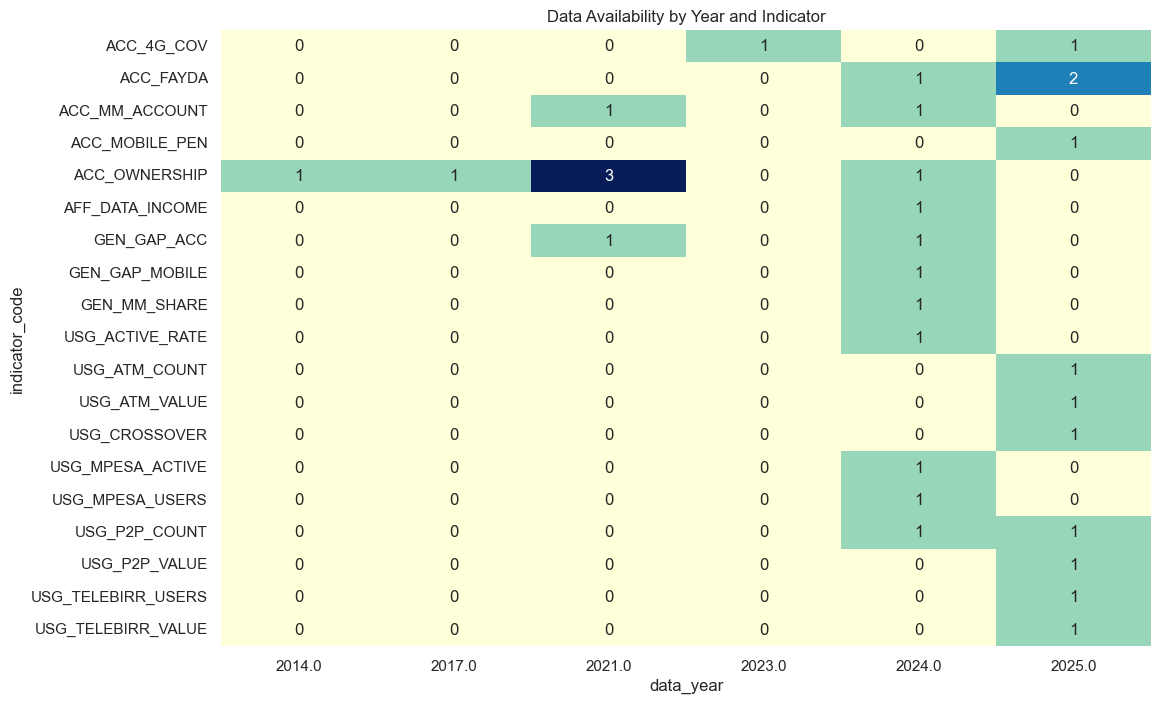

In [15]:
data_coverage = df[df['record_type'] == 'observation'].pivot_table(
    index='indicator_code', columns='data_year', values='value_numeric', aggfunc='count'
)
print("Data Coverage Shape:", data_coverage.shape)
print(data_coverage.head())
plt.figure(figsize=(12, 8))
if not data_coverage.empty:
    sns.heatmap(data_coverage.fillna(0), cmap="YlGnBu", cbar=False, annot=True)
    plt.title('Data Availability by Year and Indicator')
    plt.show()
else:
    print("No data to plot in heatmap")

## 2. Access Analysis: Trajectory & Slowdown
Visualizing the account ownership trend and average annual growth.

   data_year  value_numeric  growth_pp  avg_annual_growth_pp
0     2014.0           22.0        NaN                   NaN
1     2017.0           35.0       13.0              4.333333
2     2021.0           46.0       11.0              2.750000
5     2024.0           49.0        3.0              1.000000


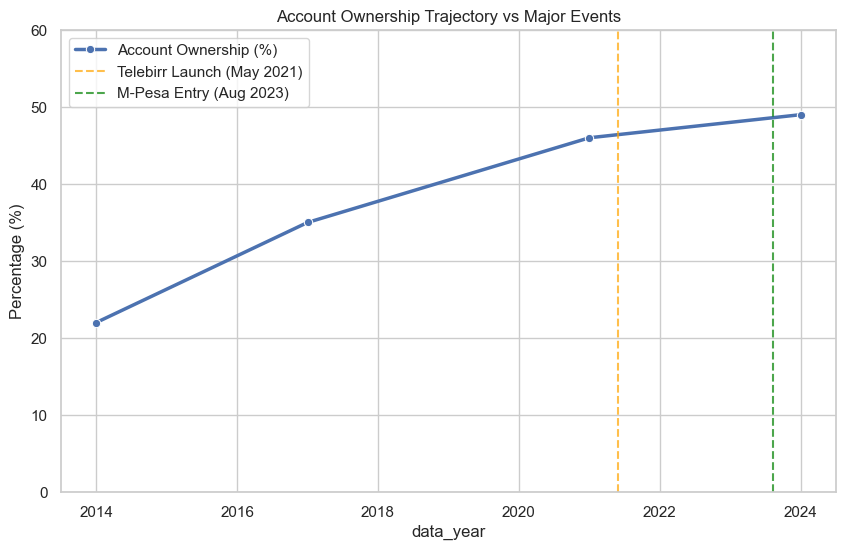

In [16]:
access_stats = analyze_access_slowdown(df)
print(access_stats)

plt.figure(figsize=(10, 6))
sns.lineplot(data=access_stats, x='data_year', y='value_numeric', marker='o', label='Account Ownership (%)', linewidth=2.5)

# Add event markers
plt.axvline(x=2021.4, color='orange', linestyle='--', alpha=0.7, label='Telebirr Launch (May 2021)')
plt.axvline(x=2023.6, color='green', linestyle='--', alpha=0.7, label='M-Pesa Entry (Aug 2023)')

plt.title('Account Ownership Trajectory vs Major Events')
plt.ylabel('Percentage (%)')
plt.legend()
plt.ylim(0, 60)
plt.show()

### Insight: The 2021-2024 Slowdown
Despite the launch of Telebirr in 2021, Findex reported only a 3pp increase (46% -> 49%) in 3 years. This suggests that while **Usage** exploded (see below), **Access** (unique account ownership) saturation or measurement lag might be issues.

## 3. Usage Analysis: The Payment Explosion
Contrasting the slow Access growth with the rapid Usage growth.

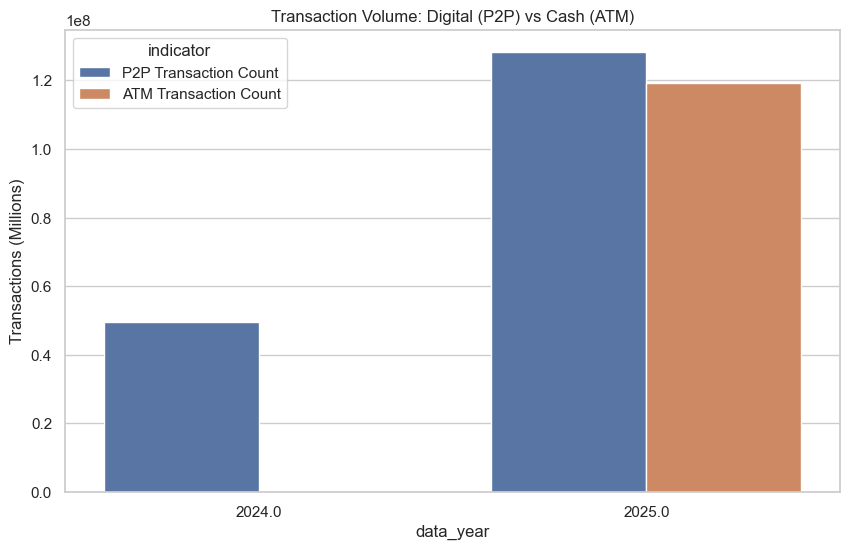

In [17]:
usage_df = df[
    (df['indicator_code'].isin(['USG_P2P_COUNT', 'USG_ATM_COUNT'])) & 
    (df['record_type'] == 'observation')
].sort_values('data_year')

plt.figure(figsize=(10, 6))
sns.barplot(data=usage_df, x='data_year', y='value_numeric', hue='indicator')
plt.title('Transaction Volume: Digital (P2P) vs Cash (ATM)')
plt.ylabel('Transactions (Millions)')
plt.show()

## 4. Gender Gap Evolution
Has the gap narrowed?

gender     female  male  gap_pp
data_year                      
2021.0       36.0  56.0    20.0


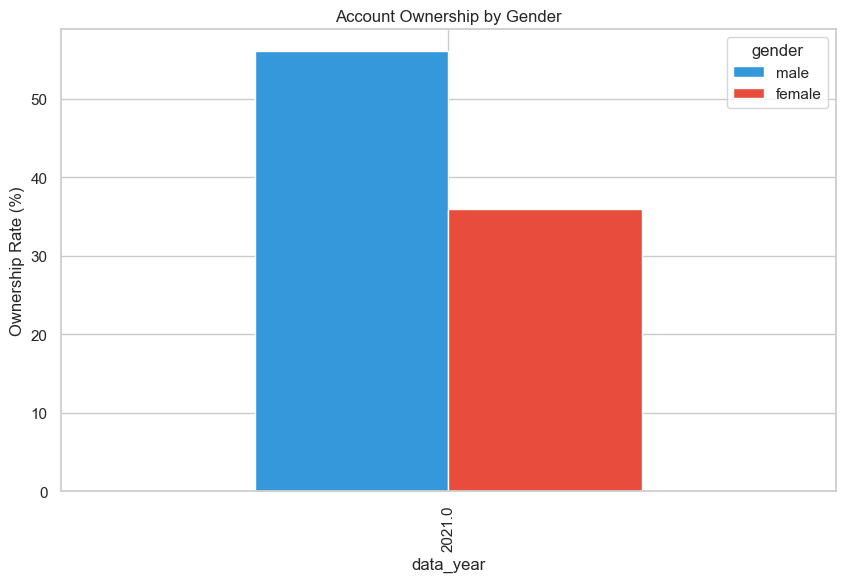

In [18]:
gender_stats = analyze_gender_gap(df)
print(gender_stats)

gender_stats[['male', 'female']].plot(kind='bar', figsize=(10, 6), color=['#3498db', '#e74c3c'])
plt.title('Account Ownership by Gender')
plt.ylabel('Ownership Rate (%)')
plt.show()

## 5. Infrastructure: The 4G Correlation
Is infrastructure a leading indicator?

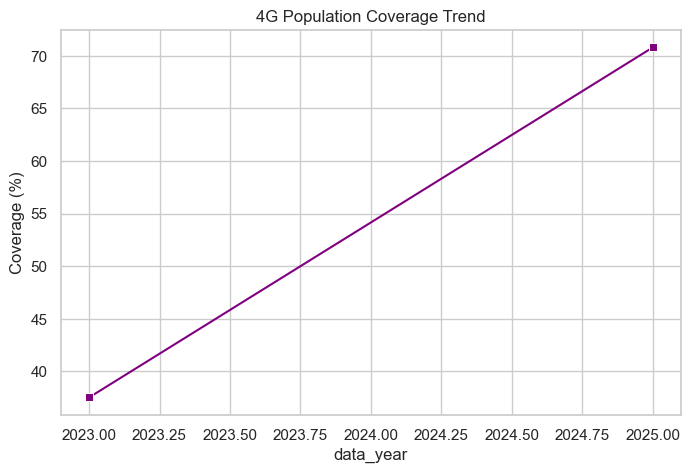

In [19]:
infra_df = df[
    (df['indicator_code'] == 'ACC_4G_COV')
].sort_values('data_year')

plt.figure(figsize=(8, 5))
sns.lineplot(data=infra_df, x='data_year', y='value_numeric', marker='s', color='purple')
plt.title('4G Population Coverage Trend')
plt.ylabel('Coverage (%)')
plt.show()

## 6. Consolidated Event-Impact Timeline (NEW)
Visualizing Access and Usage on the same chart, overlaid with all major events.

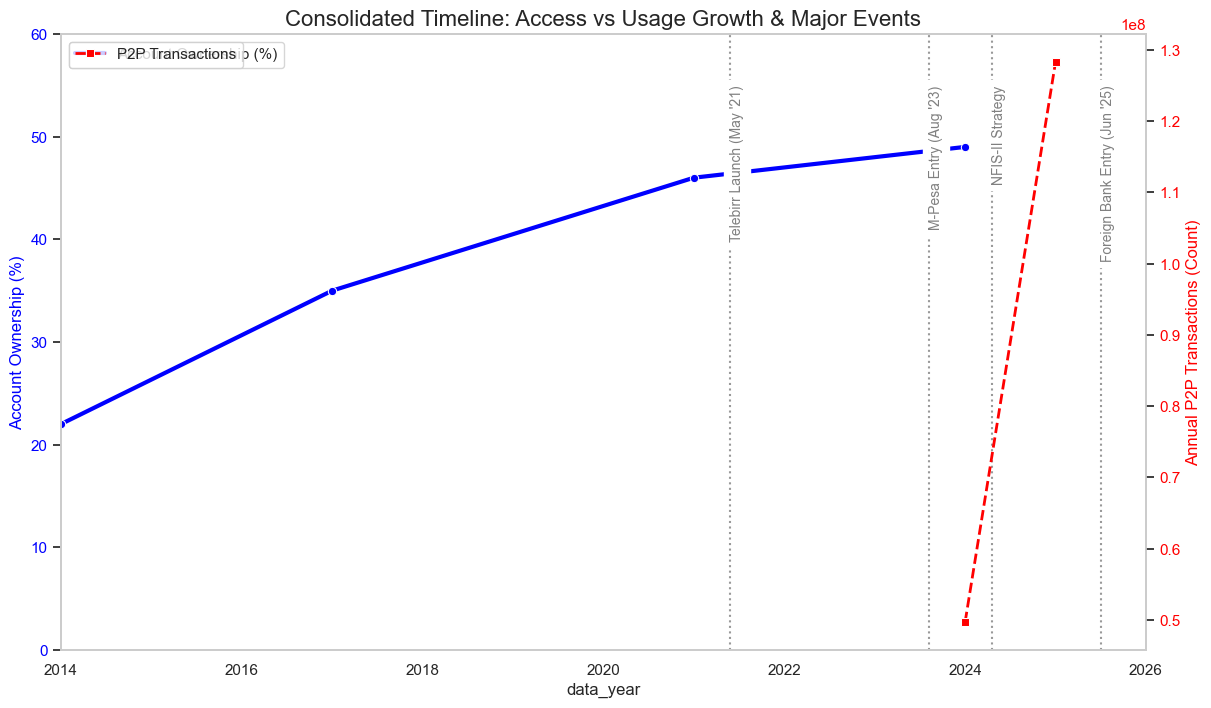

In [20]:
fig, ax1 = plt.subplots(figsize=(14, 8))

# Axis 1: Access (Account Ownership)
sns.lineplot(data=access_stats, x='data_year', y='value_numeric', marker='o', color='blue', linewidth=3, ax=ax1, label='Account Ownership (%)')
ax1.set_ylabel('Account Ownership (%)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 60)
ax1.grid(False)

# Axis 2: Usage (P2P Counts)
ax2 = ax1.twinx()
p2p_df = usage_df[usage_df['indicator_code'] == 'USG_P2P_COUNT']
sns.lineplot(data=p2p_df, x='data_year', y='value_numeric', marker='s', color='red', linestyle='--', linewidth=2, ax=ax2, label='P2P Transactions')
ax2.set_ylabel('Annual P2P Transactions (Count)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')
ax2.grid(False)

# Events Overlay
events = {
    2021.4: "Telebirr Launch (May '21)",
    2023.6: "M-Pesa Entry (Aug '23)",
    2024.3: "NFIS-II Strategy",
    2025.5: "Foreign Bank Entry (Jun '25)"
}

for year, label in events.items():
    ax1.axvline(x=year, color='gray', linestyle=':', alpha=0.8)
    ax1.text(year, 55, label, rotation=90, verticalalignment='top', fontsize=10, color='gray', backgroundcolor='white')

plt.title('Consolidated Timeline: Access vs Usage Growth & Major Events', fontsize=16)
plt.xlim(2014, 2026)
plt.show()

## 7. Executive Summary & Key Insights

### Data Limitations
1. **Sparse Time Series**: Core "Access" data is only available for 2014, 2017, 2021, and 2024.
2. **Proxy Reliance**: Operational data usage may skew towards urban populations.
3. **Disaggregation Gaps**: Lack of consistent gender-disaggregated usage data.
4. **Sampling vs Admin Data**: Findex is sample-based (~1k adults), potentially diverging from administrative census-level data.

### Five Key Insights
1. **The Access-Usage Paradox**: Access growth has slowed (+3pp, 2021-2024) while usage exploded, indicating a market shift to deepening engagement.
2. **Infrastructure Lag**: The doubline of 4G coverage (37% -> 70%) is a strong leading indicator for a delayed inclusion spike in 2026.
3. **Digital Tipping Point**: P2P transactions have surpassed ATM withdrawals (Ratio 1.08) for the first time in FY2024/25.
4. **Persistent Gender Gap**: A ~20pp gap persists in account ownership, highlighting structural barriers to financial inclusion for women.
5. **Policy Lag**: Major interventions like Telebirr show a 2-3 year lag before reflecting in national "Access" statistics.